In [1]:
import pandas as pd 
from collections import Counter
from imblearn.over_sampling import SMOTE

x_train_fe = pd.read_csv("x_train_fe.csv")
x_val_fe = pd.read_csv("x_val_fe.csv")

y_train = x_train_fe['PotentialFraud']
y_val = x_val_fe['PotentialFraud']

In [2]:
x_train = x_train_fe.drop(['PotentialFraud'], axis=1)
x_val = x_val_fe.drop(['PotentialFraud'], axis=1)

x_train.fillna(0, inplace=True)
x_val.fillna(0, inplace=True)

In [3]:
# Convert all cols to float64 to fit into tensor
X_train_float = x_train.astype('float64')

from collections import Counter
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
x_train_sm, y_train_sm = smt.fit_resample(X_train_float, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({False: 3927, True: 401})
After Counter({False: 3927, True: 3927})


#### Logistic Regression 
- Fit with everything

In [5]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

log_sm = LogisticRegressionCV(
    cv=10, 
    class_weight='balanced', 
    random_state=123,
    max_iter=10000,
    solver='saga' 
)

log_sm.fit(x_train_sm, y_train_sm)

LogisticRegressionCV(class_weight='balanced', cv=10, max_iter=10000,
                     random_state=123, solver='saga')

In [12]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

y_val_pred = log_sm.predict(x_val)
y_val_pred_probs = log_sm.predict_proba(x_val)[:, 1]
y_train_pred = log_sm.predict(x_train)

# Calculate metrics for training
precision_train = precision_score(y_train, y_train_pred)
recall_train = recall_score(y_train, y_train_pred)
accuracy_train = accuracy_score(y_train, y_train_pred)
f1_score_train = f1_score(y_train, y_train_pred)

# Calculate metrics for validation
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
accuracy_val = accuracy_score(y_val, y_val_pred)
f1_score_val = f1_score(y_val, y_val_pred)

# Organize the metrics into a DataFrame
metrics_data = {
    'Precision': [precision_train, precision_val],
    'Recall': [recall_train, recall_val],
    'Accuracy': [accuracy_train, accuracy_val],
    'F1 score': [f1_score_train, f1_score_val]
}

# Define the index labels for your DataFrame
index_labels = ['Training set eval', 'Testing set eval']

# Create the DataFrame
df_metrics = pd.DataFrame(data=metrics_data, index=index_labels)

# Display the DataFrame
print(df_metrics)

                   Precision    Recall  Accuracy  F1 score
Training set eval   0.436919  0.820449  0.885397  0.570191
Testing set eval    0.464865  0.819048  0.890943  0.593103


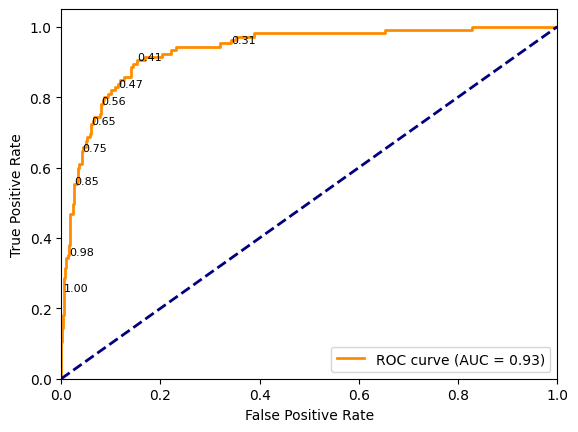

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_probs)  # y_val_pred_probs already computed
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Label a few threshold values on the curve
for i in range(1, 10, 1):
    threshold_label_index = i * len(thresholds) // 10
    plt.text(fpr[threshold_label_index], tpr[threshold_label_index], f"{thresholds[threshold_label_index]:.2f}", fontdict={'size': 8})

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#### KNN
- fit with everything

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the KNN classifier
knn_all_features = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data
knn_all_features.fit(x_train_sm, y_train_sm)

KNeighborsClassifier()

- Feature importance for top 10

In [15]:
from sklearn.inspection import permutation_importance

# Perform permutation importance
results = permutation_importance(knn_all_features, x_val, y_val, scoring='accuracy')

# Get the importance scores
importance_scores = results.importances_mean

# Map the scores with the feature names
feature_importances = dict(zip(x_train_sm.columns, importance_scores))

# Sort the feature importances in descending order and get the top 10
top_10_features = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)[:10]
print("Top 10 feature importances:", top_10_features)

Top 10 feature importances: [('COUNT(X)', 0.031608133086876135), ('SUM(X.NoOfMonths_PartACov)', 0.022920517560073916), ('SUM(X.DeductibleAmtPaid)', 0.022181146025877996), ('SUM(X.NoOfMonths_PartBCov)', 0.01959334565619224), ('NUM_UNIQUE(X.DiagnosisGroupCode_ce)', 0.015526802218114599), ('SUM(X.Age)', 0.011829944547134907), ('NUM_UNIQUE(X.ClmDiagnosisCode_9_ce)', 0.008317929759704223), ('NUM_UNIQUE(X.ClmDiagnosisCode_7_ce)', 0.00813308687615526), ('NUM_UNIQUE(X.ClmDiagnosisCode_8_ce)', 0.00813308687615526), ('NUM_UNIQUE(X.ClmProcedureCode_1_ce)', 0.008133086876155238)]


- Fit with top 10

In [16]:
# Extract the top 10 feature names
top_10_feature_names = [feature[0] for feature in top_10_features]

# Select the top 10 features from the training and validation sets
x_train_top_10 = x_train_sm[top_10_feature_names]
x_val_top_10 = x_val[top_10_feature_names]

# Initialize the KNN classifier
knn_top_10 = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN classifier to the training data with top 10 features
knn_top_10.fit(x_train_top_10, y_train_sm)

KNeighborsClassifier()

- Fit with top 10 HPT (GridSearchCV to search for the best n_neighbors)

In [17]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Initialize the KNN classifier
knn_top_10_tuned = KNeighborsClassifier()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(knn_top_10_tuned, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data with top 10 features
grid_search.fit(x_train_top_10, y_train_sm)

# Output the best parameters
print("Best parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
y_val_pred_tuned = grid_search.best_estimator_.predict(x_val_top_10)

# Calculate accuracy and other metrics as needed
accuracy_val_tuned = accuracy_score(y_val, y_val_pred_tuned)
print("Accuracy on validation set with top 10 features and hyperparameter tuning:", accuracy_val_tuned)

Best parameters: {'n_neighbors': 1}
Accuracy on validation set with top 10 features and hyperparameter tuning: 0.8567467652495379
